In [ ]:
print("Test")

In [1]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: d:\Data\Projects\llm-research-genie


In [2]:
from research_and_analyst.utils.model_loader import ModelLoader
model_loader = ModelLoader()
llm = model_loader.load_llm()

{"timestamp": "2025-10-16T23:29:22.359736Z", "level": "info", "event": "OPENAI_API_KEY loaded from environment"}
{"timestamp": "2025-10-16T23:29:22.359736Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-10-16T23:29:22.359736Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-10-16T23:29:22.359736Z", "level": "info", "event": "ASTRA_DB_API_ENDPOINT loaded from environment"}
{"timestamp": "2025-10-16T23:29:22.359736Z", "level": "info", "event": "ASTRA_DB_APPLICATION_TOKEN loaded from environment"}
{"timestamp": "2025-10-16T23:29:22.359736Z", "level": "info", "event": "ASTRA_DB_KEYSPACE loaded from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-10-16T23:29:22.359736Z", "level": "info", "event": "YAML config loaded"}
{"provider": "openai", "model": "gpt-4o", "timestamp": "2025-10-16T23:29:22.359736Z", "level": "info", "event": "Loading LLM"}
{"timestamp": 

In [4]:
llm.invoke("Hello, how are you?").content

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


"Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?"

In [5]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [6]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver

## Health 
Analyst( name="Dr. Neha Patel", role="Medical Data Scientist", affiliation="Stanford Medicine", description="Focuses on predictive models for patient outcomes." ),

Analyst( name="Dr. Arun Verma", role="Ethics Researcher", affiliation="WHO", description="Explores ethical implications of AI in diagnostics." ), Analyst( name="Ms. Priya Sharma", role="Policy Analyst", affiliation="Ministry of Health", description="Investigates AI policy and compliance frameworks." )

In [33]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

In [34]:
Analyst(
    name="John Doe",
    role="AI Engineer",
    affiliation="AI Research LAB",
    description="I am AI Engineer  with a focus on creating and deploying AI models for various applications."
    )

Analyst(name='John Doe', role='AI Engineer', affiliation='AI Research LAB', description='I am AI Engineer  with a focus on creating and deploying AI models for various applications.')

In [35]:
analyst = Analyst(
    name="John Doe",
    role="AI Engineer",
    affiliation="AI Research LAB",
    description="I am AI Engineer  with a focus on creating and deploying AI models for various applications."
    )

In [ ]:
analyst.persona

Name: John Doe
Role: AI Engineer
Affiliation: AI Research LAB
Description: I am AI Engineer  with a focus on creating and deploying AI models for various applications.




In [37]:
analyst.name

'John Doe'

In [39]:
print(analyst.persona)

Name: John Doe
Role: AI Engineer
Affiliation: AI Research LAB
Description: I am AI Engineer  with a focus on creating and deploying AI models for various applications.




In [40]:
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [41]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    

In [42]:
GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'give the real info'}

In [43]:
Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
    ),

(Analyst(name='Dr. Neha Patel', role='Medical Data Scientist', affiliation='Stanford Medicine', description='Focuses on predictive models for patient outcomes.'),)

In [44]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [45]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']



In [46]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

In [47]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Emily Chen', role='Public Health Researcher', affiliation='World Health Organization', description='Dr. Emily Chen focuses on global health trends and the impact of public health policies on disease prevention and health promotion. Her primary concern is understanding how different health policies can be optimized to improve health outcomes across diverse populations. She is motivated by the need to address health disparities and ensure equitable access to healthcare services worldwide.'),
  Analyst(name='Dr. Raj Patel', role='Healthcare Technology Analyst', affiliation='Harvard T.H. Chan School of Public Health', description='Dr. Raj Patel specializes in the intersection of technology and healthcare, particularly how digital health innovations can transform patient care and health system efficiency. His focus is on evaluating the effectiveness of telemedicine, wearable health devices, and AI-driven diagnostics. He is driven by the potential of technolog

In [48]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [49]:
def should_continue(state):
    """ Return the next node to execute """
    human_analyst_feedback = state.get("human_analyst_feedback",None)
    if human_analyst_feedback:
        return "create_analyst"

In [50]:
from IPython.display import Image, display

## 1. Analyst Workflow

In [164]:
builder = StateGraph(GenerateAnalystsState)

In [52]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)

In [165]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])

In [54]:
memory = MemorySaver()

In [55]:
graph = builder.compile(interrupt_before= ["human_feedback"],checkpointer= memory)

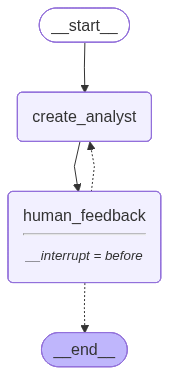

In [56]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [57]:
topic = "the benefits of adopting Langgraph as an agent framework"
max_analysts = 4
thread =  {"configurable":{"thread_id":1}}

In [58]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Chen focuses on the strategic benefits of adopting new technologies like Langgraph. She is particularly interested in how Langgraph can streamline processes and improve efficiency in various industries. Her motive is to identify technologies that can provide a competitive edge to businesses.
--------------------------------------------------
Name: Raj Patel
Affiliation: FutureTech Research Group

Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Chen focuses on the strategic benefits of adopting new technologies like Langgraph. She is particularly interested in how Langgraph can streamline processes and improve efficiency in various industries. Her motive is to identify technologies that can provide a competitive edge to businesses.
--------------------------------------------------
Name: Raj Patel
Affiliation: FutureTech Research Group
Role

In [231]:
state = graph.get_state(thread)

In [60]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Dr. Emily Chen', role='Technology Adoption Specialist', affiliation='Tech Innovators Inc.', description='Dr. Chen focuses on the strategic benefits of adopting new technologies like Langgraph. She is particularly interested in how Langgraph can streamline processes and improve efficiency in various industries. Her motive is to identify technologies that can provide a competitive edge to businesses.'), Analyst(name='Raj Patel', role='AI Framework Analyst', affiliation='FutureTech Research Group', description='Raj Patel analyzes different AI frameworks and their impact on development processes. He is concerned with the flexibility and scalability of Langgraph as an agent framework, and how it compares to other frameworks in terms of ease of integration and performance.'), Analyst(name='Sophia Martinez', role='Business Process Consultant', affiliation='G

In [232]:
state.values

{'topic': 'How can generative AI accelerate drug discovery?',
 'max_analysts': 3,
 'analysts': [Analyst(name='Dr. Emily Chen', role='AI and Computational Biology Expert', affiliation='Stanford University', description='Dr. Chen focuses on the integration of generative AI models with biological data to enhance the drug discovery process. Her primary concern is ensuring that AI models are trained on diverse and comprehensive datasets to improve their predictive accuracy and reliability. She is motivated by the potential of AI to significantly reduce the time and cost associated with bringing new drugs to market.'),
  Analyst(name='Dr. Raj Patel', role='Pharmaceutical Industry Strategist', affiliation='Pfizer', description='Dr. Patel analyzes the strategic implications of adopting generative AI in pharmaceutical companies. He is particularly interested in how AI can streamline the drug development pipeline, from target identification to clinical trials. His concerns include the regulatory

In [62]:

state.next

('human_feedback',)

In [63]:
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0aae9f-3109-6c1c-bfff-4b467a8dbd68': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-16T23:43:43.053929+00:00\xa2id\xd9$1f0aae9f-3109-6c1c-bfff-4b467a8dbd68\xb0channel_versions\x81\xa9__start__\xd9400000000000000000000000000000001.0.09886794216755856\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0aae9f-310c-636b-8000-fc4bffd7a0c7': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-16T23:43:43.054935+00:00\xa2id\xd9$1f0aae9f-310c-636b-8000-fc4bffd7a0c7\xb0channel_versions\x84\xa9__start__\xd9400000000000000000000000000000002.0.07639650891392036\xa5topic\xd9400000000000000000000000000000002.0.07639650891392036\xacmax_analysts\xd9400000000000000000000000000000002.0.07639650891392036\xb8branch:to:create_analyst\xd9400000000000000000000000000000002.0.07639650891392036\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start

In [ ]:
# import msgpack

# for thread_id, ns_dict in memory.storage.items():
#     print(f"\n Thread ID: {thread_id}")
    
#     # ns_dict = defaultdict(dict, {'': {...}})
#     for ns, ckpts in ns_dict.items():
#         print(f"  Namespace: '{ns}'")
        
#         # ckpts = dict of {checkpoint_id: (packed_values, packed_metadata, parent_id)}
#         for ckpt_id, (packed_values, packed_metadata, parent_id) in ckpts.items():
#             print(f"    Checkpoint ID: {ckpt_id}")
            
#             # Decode msgpack binary
#             values = msgpack.unpackb(packed_values[1], raw=False)
#             meta = msgpack.unpackb(packed_metadata[1], raw=False)
            
#             print(f"    Values keys: {list(values.keys())}")
#             print(f"    Parent ID: {parent_id}")
#             print(f"    Metadata: {meta}")
#             print("-" * 80)

In [64]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0aae9f-578c-6dbf-8001-b0f25fd5439b'}}

In [235]:
graph.update_state(thread,
                   {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"},
                   as_node="human_feedback"
                   )

KeyError: 'create_analyst'

In [68]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Chen
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Chen focuses on the strategic benefits of adopting new technologies like Langgraph. She is particularly interested in how Langgraph can streamline processes and improve efficiency in various industries. Her motive is to identify technologies that can provide a competitive edge to businesses.
--------------------------------------------------
Name: Raj Patel
Affiliation: FutureTech Research Group
Role: AI Framework Analyst
Description: Raj Patel analyzes different AI frameworks and their impact on development processes. He is concerned with the flexibility and scalability of Langgraph as an agent framework, and how it compares to other frameworks in terms of ease of integration and performance.
--------------------------------------------------
Name: Sophia Martinez
Affiliation: Global Solutions Ltd.
Role: Business Process Consultant
Description: Sophia Martinez examines how Lang

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Sophia Tran
Affiliation: Tech Innovators Network
Role: Startup Ecosystem Analyst
Description: Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for startups. Her analysis often includes case studies of early-stage companies that have successfully integrated Langgraph into their workflows.
--------------------------------------------------
Name: Michael Chen
Affiliation: Global Enterprise Solutions
Role: Enterprise Application Specialist
Affiliation: Tech Innovators Network
Role: Startup Ecosystem Analyst
Description: Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for startups. Her analysis often includes case studies of early-stage companies that have s

In [69]:
state = graph.get_state(thread)

In [70]:

state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for startups. Her analysis often includes case studies of early-stage companies that have successfully integrated Langgraph into their workflows.'), Analyst(name='Michael Chen', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description='Michael specializes in the latest enterprise applications and how they can be optimized using frameworks like Langgraph. He examines how large organizati

In [71]:

state.next

('human_feedback',)

In [72]:

state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application',
 'analysts': [Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for startups. Her analysis often includes case studies of early-stage companies that have successfully integrated Langgraph into their workflows.'),
  Analyst(name='Michael Chen', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description='Michael specializes in the latest enterprise applications and how they can be optimized using frameworks like Langgraph. He examines how large organizations can leverage

In [ ]:
# import msgpack

# def get_all_checkpoints(memory, thread_id="1"):
#     """Return all checkpoints in chronological order for a thread."""
#     checkpoints = []
#     ns_dict = memory.storage.get(thread_id, {})
#     if "" not in ns_dict:
#         return []

#     for ckpt_id, (packed_values, packed_meta, parent_id) in ns_dict[""].items():
#         values = msgpack.unpackb(packed_values[1], raw=False)
#         meta = msgpack.unpackb(packed_meta[1], raw=False)
#         checkpoints.append({
#             "id": ckpt_id,
#             "parent": parent_id,
#             "topic": values.get("topic"),
#             "feedback": values.get("human_analyst_feedback"),
#             "analyst_count": len(values.get("analysts", [])),
#             "analysts": [a.model_dump() for a in values.get("analysts", [])],
#             "step": meta.get("step"),
#             "created_at": values.get("ts", None)
#         })
#     return checkpoints

# # Fetch all
# history = get_all_checkpoints(memory)

# # Sort by step (to get chronological order)
# history = sorted(history, key=lambda x: (x["step"] or 0))

# # Display neatly
# for h in history:
#     print(f"\nSTEP {h['step']} | CHECKPOINT {h['id']}")
#     print(f"Parent: {h['parent']}")
#     print(f"Topic: {h['topic']}")
#     print(f"Feedback: {h['feedback']}")
#     print(f"Analysts generated: {h['analyst_count']}")
#     print("-"*100)

In [73]:
# If we are satisfied, then we simply supply no feedback
further_feedack = ""

In [76]:
# 1) Get the latest state (you're paused at 'human_feedback')
state = graph.get_state(thread)

# 2) Use the exact config from that state (it already has thread_id, checkpoint_ns, checkpoint_id)
cfg = state.config

In [77]:
# 3) Update feedback at the 'human_feedback' node
#    Tip: if your TypedDict says `human_analyst_feedback: str`, prefer "" (empty string) over None
graph.update_state(cfg, {"human_analyst_feedback": ""}, as_node="human_feedback")

KeyError: None

In [78]:
# 4) Verify it moved to END
final_state = graph.get_state(thread)
print(final_state.next)  # should be (END,)

('human_feedback',)



In [79]:
analysts = final_state.values.get('analysts')

In [80]:
analysts

[Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for startups. Her analysis often includes case studies of early-stage companies that have successfully integrated Langgraph into their workflows.'),
 Analyst(name='Michael Chen', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description='Michael specializes in the latest enterprise applications and how they can be optimized using frameworks like Langgraph. He examines how large organizations can leverage Langgraph to improve efficiency, enhance data processing capabilities, and support complex decision-making processes. His insights are geared towards CIOs and IT managers looking to modernize their tech stack.'),
 Analyst(n

In [81]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Sophia Tran
Affiliation: Tech Innovators Network
Role: Startup Ecosystem Analyst
Description: Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for startups. Her analysis often includes case studies of early-stage companies that have successfully integrated Langgraph into their workflows.
--------------------------------------------------
Name: Michael Chen
Affiliation: Global Enterprise Solutions
Role: Enterprise Application Specialist
Description: Michael specializes in the latest enterprise applications and how they can be optimized using frameworks like Langgraph. He examines how large organizations can leverage Langgraph to improve efficiency, enhance data processing capabilities, and support complex decision-making processes. His insights are geared towards CIOs and IT managers looking to modernize their tech st

In [82]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 



In [84]:
from langchain_community.document_loaders import WikipediaLoader
docs = WikipediaLoader(query="Pneumatic UI").load()
print(docs[0].page_content[:500])

LonWorks or Local Operating Network is an open standard (ISO/IEC 14908) for networking platforms specifically created to address the needs of control applications. The platform is built on a protocol created by Echelon Corporation for networking devices over media such as twisted pair, power lines, fiber optics, and wireless. It is used for the automation of various functions within buildings such as lighting and HVAC; see building automation.


== Origins and uptake ==
The technology had its or



In [85]:
from langchain_community.document_loaders import WikipediaLoader
docs = WikipediaLoader(query="The benefits of adopting AWS Cloud").load()
print(docs)

[Document(metadata={'title': 'Cloud computing', 'summary': 'Cloud computing is "a paradigm for enabling network access to a scalable and elastic pool of shareable physical or virtual resources with self-service provisioning and administration on-demand," according to ISO. It is commonly referred to as "the cloud".\n\n', 'source': 'https://en.wikipedia.org/wiki/Cloud_computing'}, page_content='Cloud computing is "a paradigm for enabling network access to a scalable and elastic pool of shareable physical or virtual resources with self-service provisioning and administration on-demand," according to ISO. It is commonly referred to as "the cloud".\n\n\n== Characteristics ==\nIn 2011, the National Institute of Standards and Technology (NIST) identified five "essential characteristics" for cloud systems. Below are the exact definitions according to NIST:\n\nOn-demand self-service: "A consumer can unilaterally provision computing capabilities, such as server time and network storage, as neede

In [ ]:
from langchain_community.document_loaders import WikipediaLoader
docs = WikipediaLoader(query="AWS").load()
print(docs[0].page_content[:500])

In [ ]:
# Use Wikipedia API Wrapper instead of Wikipedia Loader
# Wikipedia Returning unrelevant results. Use Google Serper or duckduckgo instead
from langchain_community.utilities import WikipediaAPIWrapper

In [ ]:
wiki = WikipediaAPIWrapper(doc_content_chars_max=4000)
docs = wiki.run("The benefits of adopting LangGraph as an agentic framework")
print(docs)

## 2. Research Workflow

In [86]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [87]:
from dotenv import load_dotenv
load_dotenv()
import os
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [88]:
tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)

C:\Users\iss_s\AppData\Local\Temp\ipykernel_122184\1029971610.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)


In [89]:
tavily_search.invoke("langgraph")

[{'title': 'Learn LangGraph basics - Overview',
  'url': 'https://langchain-ai.github.io/langgraph/concepts/why-langgraph/',
  'content': 'Trusted by companies shaping the future of agents— including Klarna, Replit, Elastic, and more— LangGraph is a low-level orchestration framework and runtime for building, managing, and deploying long-running, stateful agents.\nLangGraph is very low-level, and focused entirely on agent orchestration. Before using LangGraph, we recommend you familiarize yourself with some of the components used to build agents, starting with models and tools.',
  'score': 0.9310187},
 {'title': 'LangGraph Overview - Docs by LangChain',
  'url': 'https://docs.langchain.com/oss/python/langgraph/overview',
  'content': 'Trusted by companies shaping the future of agents - including Klarna, Replit, Elastic, and more - LangGraph is a low-level orchestration framework for building, managing, and deploying long-running, stateful agents.LangGraph is very low-level, and focused

In [90]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 



In [91]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [92]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [93]:
print(analyst.persona)

Name: Liam O'Reilly
Role: Business Strategy Consultant
Affiliation: FutureTech Consulting
Description: Liam advises businesses on strategic adoption of emerging technologies. He focuses on how Langgraph can be a game-changer in aligning business strategies with technological advancements. His analysis includes market trends, competitive advantages, and long-term benefits of integrating Langgraph into business models, particularly for companies looking to stay ahead in the digital transformation race.




In [94]:
question_instructions.format(goals = analyst.persona)

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Liam O\'Reilly\nRole: Business Strategy Consultant\nAffiliation: FutureTech Consulting\nDescription: Liam advises businesses on strategic adoption of emerging technologies. He focuses on how Langgraph can be a game-changer in aligning business strategies with technological advancements. His analysis includes market trends, competitive advantages, and long-term benefits of integrating Langgraph into business models, particularly for companies looking to stay ahead in the digital transformation race.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your que

In [95]:
'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Michael Chen\nRole: Business Strategy Consultant\nAffiliation: FutureTech Consulting\nDescription: Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"\n\nRemember to stay in character throughout your response, reflecting the persona and goals provided to you.'

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Michael Chen\nRole: Business Strategy Consultant\nAffiliation: FutureTech Consulting\nDescription: Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with your understanding, complete the interview with: "Thank you

In [96]:
def generation_question(state:InterviewState):
    """Node to generate the questions"""
    
    #get state
    analyst = state["analyst"]
    messages = state["messages"]
    
    #generate the question
    system_message = question_instructions.format(goals = analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
    
    #returen the question through state
    return {"messages":[question]}

In [97]:
analyst

Analyst(name="Liam O'Reilly", role='Business Strategy Consultant', affiliation='FutureTech Consulting', description='Liam advises businesses on strategic adoption of emerging technologies. He focuses on how Langgraph can be a game-changer in aligning business strategies with technological advancements. His analysis includes market trends, competitive advantages, and long-term benefits of integrating Langgraph into business models, particularly for companies looking to stay ahead in the digital transformation race.')

In [98]:
class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

In [99]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],"messages":[HumanMessage(content="hi do the proper search according to the experties")]}

In [100]:
state

{'max_num_turns': 2,
 'context': [],
 'analyst': Analyst(name="Liam O'Reilly", role='Business Strategy Consultant', affiliation='FutureTech Consulting', description='Liam advises businesses on strategic adoption of emerging technologies. He focuses on how Langgraph can be a game-changer in aligning business strategies with technological advancements. His analysis includes market trends, competitive advantages, and long-term benefits of integrating Langgraph into business models, particularly for companies looking to stay ahead in the digital transformation race.'),
 'interview': '',
 'section': [],
 'messages': [HumanMessage(content='hi do the proper search according to the experties', additional_kwargs={}, response_metadata={})]}

In [101]:
result = generation_question(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [102]:
result

{'messages': [AIMessage(content="Hello, my name is Alex Carter, and I'm an analyst interested in understanding the strategic adoption of emerging technologies in business. I'm particularly curious about Langgraph and its potential impact on business strategies. Could you explain how Langgraph can be a game-changer for companies looking to align their strategies with technological advancements?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 255, 'total_tokens': 316, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CRUD5zEOmXGi95uHTThLQ89BMFOra', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--7f5e12d1-2dc1-4818-88fd-c4ed2b122faf-0', usage_metada

In [103]:
print(result["messages"][0].content)

Hello, my name is Alex Carter, and I'm an analyst interested in understanding the strategic adoption of emerging technologies in business. I'm particularly curious about Langgraph and its potential impact on business strategies. Could you explain how Langgraph can be a game-changer for companies looking to align their strategies with technological advancements?



In [104]:
from langchain_core.messages import get_buffer_string

In [105]:
# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [106]:
def search_web(state:InterviewState):
    """
    Retrieve data from the web
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    search_query = structure_llm.invoke([search_instructions]+state["messages"])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [110]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [175]:
result = search_web(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [176]:
print(result["context"][0])

<Document href="https://medium.com/@dr.jarkko.moilanen/why-i-took-the-langgraph-course-as-a-business-level-product-head-facde7ba3118"/>
Despite my focus on business strategy and AI leadership, taking the LangGraph course offered numerous benefits. Understanding the technical foundations of AI systems improved communication with developers, engineers, and data scientists, ensuring accurate requirement definitions for complex solutions. It also enhanced my ability to make informed decisions by providing context for assessing feasibility, estimating effort, and identifying risks. With a stronger technical foundation, I could [...] Moreover, technical knowledge strengthened collaboration across teams by fostering a shared language. It also contributed to defining value propositions, pricing strategies, and business models for data products by providing a deeper understanding of how data is collected, processed, and consumed. Keeping up with evolving technologies like LangGraph helps mainta

In [177]:
def search_wikipedia(state:InterviewState):
    """
    Retrieve data from wiki
    """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    print("*******************************")
    print(search_query)
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

In [178]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [179]:

result = search_wikipedia(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph framework benefits for business innovation and digital transformation'

search_query='Langgraph framework benefits for business innovation and digital transformation'


In [180]:
search_docs = WikipediaLoader(query='Langgraph framework benefits',load_all_available_meta=True).load()

In [181]:
search_docs

[]

In [182]:
result

{'context': ['']}

In [183]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [184]:
def generate_answer(state:InterviewState):
   
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

In [185]:
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

In [186]:
def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

In [187]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [188]:
def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

In [213]:
interview_builder = StateGraph(InterviewState)

In [214]:
interview_builder.add_node("ask_question",generation_question)
interview_builder.add_node("search_web",search_web)
interview_builder.add_node("search_wikipedia",search_wikipedia)
interview_builder.add_node("generate_answer",generate_answer)
interview_builder.add_node("save_interview",save_interview)
interview_builder.add_node("write_section",write_section)

In [215]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web","generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                           route_messages,
                           ["ask_question",
                            "save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)

In [216]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")

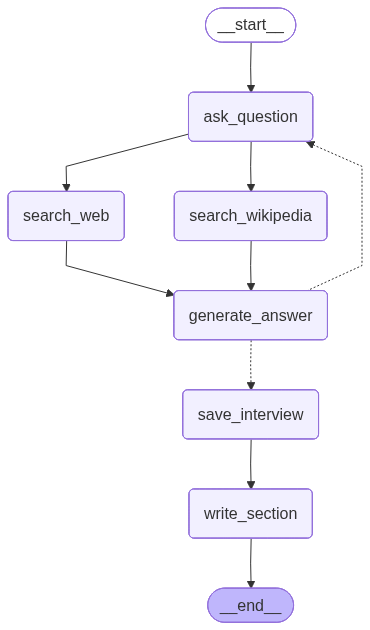

In [217]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [194]:
analyst

Analyst(name="Liam O'Reilly", role='Business Strategy Consultant', affiliation='FutureTech Consulting', description='Liam advises businesses on strategic adoption of emerging technologies. He focuses on how Langgraph can be a game-changer in aligning business strategies with technological advancements. His analysis includes market trends, competitive advantages, and long-term benefits of integrating Langgraph into business models, particularly for companies looking to stay ahead in the digital transformation race.')

In [195]:
analyst.persona

"Name: Liam O'Reilly\nRole: Business Strategy Consultant\nAffiliation: FutureTech Consulting\nDescription: Liam advises businesses on strategic adoption of emerging technologies. He focuses on how Langgraph can be a game-changer in aligning business strategies with technological advancements. His analysis includes market trends, competitive advantages, and long-term benefits of integrating Langgraph into business models, particularly for companies looking to stay ahead in the digital transformation race.\n"

In [196]:
thread = {"configurable": {"thread_id": "1"}}

In [197]:
from IPython.display import Markdown

In [198]:
messages = [HumanMessage("So you said you were writing an article on Langchain?")]

In [199]:
interview = interview_graph.invoke({"analyst": analyst, "messages": messages, "max_num_turns": 2}, thread)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph strategic implications for businesses technology alignment advantages over other technologies'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph integration success stories in business models tangible benefits'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [200]:
Markdown(interview['sections'][0])

## Langgraph: A Strategic Game-Changer for Business Technology Alignment

### Summary

In the rapidly evolving landscape of AI and technology, businesses are constantly seeking innovative solutions to stay competitive. Langgraph emerges as a pivotal framework for enterprises aiming to align their business strategies with technological advancements. This report delves into the strategic advantages of adopting Langgraph, highlighting its potential to transform business models and maintain a competitive edge in the digital transformation race.

Langgraph is not just a technical tool; it represents a strategic shift in how businesses can leverage AI for complex, real-world applications. Unlike its predecessor, LangChain, which is suitable for rapid development and straightforward applications, Langgraph is designed for sophisticated, production-grade AI systems. It excels in handling complex workflows, stateful processes, and multi-agent coordination, making it ideal for enterprises looking to implement robust AI solutions [1][2].

One of the most compelling aspects of Langgraph is its ability to scale efficiently, offering better ROI for large-scale deployments. Its architecture supports modular, scalable systems with advanced memory management, error handling, and observability, crucial for mission-critical enterprise applications [1][3]. This makes Langgraph particularly appealing for industries such as retail, healthcare, and telecommunications, where real-world complexity and continuous change are prevalent [3][4].

Langgraph's integration capabilities are another significant advantage. It seamlessly connects with major tools and models, including OpenAI, Anthropic, and enterprise APIs, allowing businesses to incorporate it into their existing tech stacks without significant overhead [5]. This flexibility ensures that companies can maintain their current workflows while enhancing them with Langgraph's advanced features.

Moreover, Langgraph's strategic implications extend beyond technical benefits. It offers businesses a pathway to bridge the gap between automation and true personalization, particularly in sectors like retail, where customer interactions and operational efficiency are paramount [3]. By enabling more reliable, scalable, and stateful AI agents, Langgraph empowers businesses to move from static models to adaptive systems that learn and respond with context.

In conclusion, Langgraph represents a strategic opportunity for businesses to harness the power of AI in a way that aligns with their long-term goals. Its robust framework, scalability, and integration capabilities make it a game-changer for enterprises looking to lead in the digital transformation era. As businesses continue to navigate the complexities of AI adoption, understanding and implementing Langgraph could be the key to unlocking new levels of innovation and competitiveness.

### Sources
[1] https://thirdeyedata.ai/a-comparative-study-between-langgraph-and-langchain-for-enterprise-ai-development/  
[2] https://medium.com/@nagarjunmallesh/beyond-the-chain-why-langgraph-represents-a-strategic-shift-for-enterprise-grade-ai-15411ddb8529  
[3] https://interviewkickstart.com/blogs/articles/langgraph-for-retail-ai-agent  
[4] https://www.designveloper.com/blog/langgraph-vs-langchain-comparison/  
[5] https://www.ema.co/additional-blogs/addition-blogs/building-ai-agents-langgraph  

## 3. Build Report Workflow

In [201]:
from typing_extensions import Annotated, List
from langgraph.graph import MessagesState
import operator

In [202]:
class ResearchGraphState(TypedDict):
    topic: str # Final research report
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[List, operator.add] # Final report sections
    introduction: str # Introduction section
    content: str # Final research report
    conclusion: str # Conclusion section
    final_report: str # Final research report

In [203]:
from langgraph.types import Send

In [204]:
def initiate_all_interviews(state:ResearchGraphState):
    """ Initialize all interviews for each analyst """

    # Check if human feedback is provided
    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        return "create_analyst"
    else:
        topic = state["topic"]
        return[Send("conduct_interview", {"analyst": analyst, 
                                          "messages": [HumanMessage(content=f"Please conduct an interview on the topic: {topic}")] ,
                                          "context": []}) for analyst in state["analysts"]]
   

In [220]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [221]:
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

In [219]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

In [207]:
def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

In [209]:
def write_conclusion(state:ResearchGraphState):
    """ Write report conclusion based on interviews """
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n".join([f"- {section}" for section in sections])

    instructions = report_writer_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = llm.invoke([instructions] + [HumanMessage(content="Write the conclusion section of the report.")])
    return {"conclusion": conclusion.content}

In [210]:
def finalize_report(state:ResearchGraphState):
    """ Finalize the report by combining all sections """
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")

    if "## Sources" in content:
        try:
            content, sources = content.split("## Sources", 1)
            content = content.strip()
            sources = sources.strip()
        except:
            sources = None
    else:
        sources = None

    introduction = state["introduction"]
    content = state["content"]
    conclusion = state["conclusion"]

    final_report = f"{introduction}\n\n{content}\n\n{conclusion}"
    if sources is not None:
        final_report += f"\n\n## Sources\n\n{sources}"
    return {"final_report": final_report}

In [222]:
# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("initiate_all_interviews", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "initiate_all_interviews"])
builder.add_edge("initiate_all_interviews", "write_report")
builder.add_edge("initiate_all_interviews", "write_introduction")
builder.add_edge("initiate_all_interviews", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

In [223]:
memory = MemorySaver()

In [224]:
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

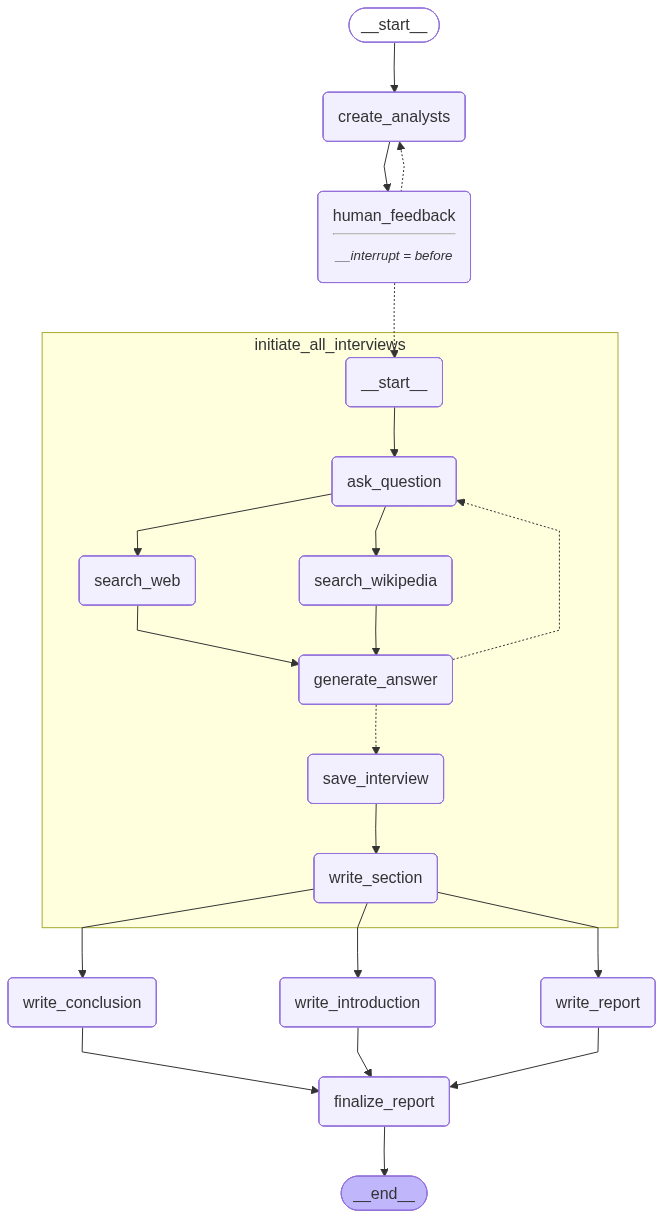

In [225]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [226]:
max_analysts = 3

In [227]:
topic = "How can generative AI accelerate drug discovery?"

In [228]:
thread = {"configurable": {"thread_id": "1"}}

In [229]:
# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Affiliation: Stanford University
Role: AI and Computational Biology Expert
Description: Dr. Chen focuses on the integration of generative AI models with biological data to enhance the drug discovery process. Her primary concern is ensuring that AI models are trained on diverse and comprehensive datasets to improve their predictive accuracy and reliability. She is motivated by the potential of AI to significantly reduce the time and cost associated with bringing new drugs to market.
--------------------------------------------------
Name: Dr. Raj Patel
Affiliation: Pfizer
Role: Pharmaceutical Industry Strategist
Description: Dr. Patel analyzes the strategic implications of adopting generative AI in pharmaceutical companies. He is particularly interested in how AI can streamline the drug development pipeline, from target identification to clinical trials. His concerns include the regulatory challenges and the need for industry-wide standards to ensure AI-driven disco

In [230]:
graph.update_state(thread, {"human_analyst_feedback":"along with the genetive ai in future tell me the future of indian team"}, as_node="human_feedback")

KeyError: 'create_analyst'

In [236]:
# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Chen
Affiliation: Stanford University
Role: AI and Computational Biology Expert
Description: Dr. Chen focuses on the integration of generative AI models with biological data to enhance the drug discovery process. Her primary concern is ensuring that AI models are trained on diverse and comprehensive datasets to improve their predictive accuracy and reliability. She is motivated by the potential of AI to significantly reduce the time and cost associated with bringing new drugs to market.
--------------------------------------------------
Name: Dr. Raj Patel
Affiliation: Pfizer
Role: Pharmaceutical Industry Strategist
Description: Dr. Patel analyzes the strategic implications of adopting generative AI in pharmaceutical companies. He is particularly interested in how AI can streamline the drug development pipeline, from target identification to clinical trials. His concerns include the regulatory challenges and the need for industry-wide standards to ensure AI-driven disco

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Affiliation: Stanford University
Role: AI and Computational Biology Expert
Description: Dr. Chen focuses on the integration of generative AI models with biological data to enhance the drug discovery process. Her primary concern is ensuring that AI models are trained on diverse and comprehensive datasets to improve their predictive accuracy and reliability. She is motivated by the potential of AI to significantly reduce the time and cost associated with bringing new drugs to market.
--------------------------------------------------
Name: Dr. Raj Patel
Affiliation: Pfizer
Role: Pharmaceutical Industry Strategist
Description: Dr. Patel analyzes the strategic implications of adopting generative AI in pharmaceutical companies. He is particularly interested in how AI can streamline the drug development pipeline, from target identification to clinical trials. His concerns include the regulatory challenges and the need for industry-wide standards to ensure AI-driven disco

In [237]:
graph.update_state(thread, {"human_analyst_feedback":""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ad664-b3dd-6b0f-8005-45feec627767'}}

In [238]:
graph.get_state(thread).next

Ignoring unknown node name conduct_interview in pending sends
Ignoring unknown node name conduct_interview in pending sends
Ignoring unknown node name conduct_interview in pending sends


()

In [239]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

Ignoring unknown node name conduct_interview in pending sends
Ignoring unknown node name conduct_interview in pending sends
Ignoring unknown node name conduct_interview in pending sends
Ignoring unknown node name conduct_interview in pending sends
Ignoring unknown node name conduct_interview in pending sends


In [240]:

from IPython.display import Markdown

In [241]:

final_state = graph.get_state(thread)

Ignoring unknown node name conduct_interview in pending sends
Ignoring unknown node name conduct_interview in pending sends
Ignoring unknown node name conduct_interview in pending sends
Ignoring unknown node name conduct_interview in pending sends
Ignoring unknown node name conduct_interview in pending sends


In [242]:

report = final_state.values.get('final_report')

In [243]:
Markdown(report)

<IPython.core.display.Markdown object>